### <span style="color:rgb(92,29,79)">Optimization for Machine Learning</span>

### <span style="color:rgb(92,29,79)">Master 2 ID Apprentissage 2024-2025</span>


# <span style="color:rgb(92,29,79)">Lab 02 - Gradient descent and nonconvex functions</span>


Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OID/PolyOID.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OID/LabOID02.zip).

The NumPy library is used in this lab. A quick and useful tutorial for NumPy is available 
[here](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@lamsade.dauphine.fr**.

# <span style="color:rgb(92,29,79)">Introduction</span>

This lab session aims at illustrating the use of gradient descent techniques on nonconvex optimization problems. In that setting, gradient descent is not theoretically guaranteed to converge towards a local minimum, but in practice is often observed to do so.


*Note: All blocks of this notebook are built to be run sequentially. In particular, the block below should be executed before going any further.*

In [13]:
# Preamble: useful toolboxes, librairies, functions, etc.

# Display
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform, choice # Probability distributions

# SciPy - Efficient mathematical calculation
from scipy.linalg import norm # Euclidean norm
from scipy.linalg import toeplitz # Toeplitz matrices
from scipy.linalg import svdvals # Singular value decomposition
from scipy.optimize import check_grad # Check derivatives
from scipy.optimize import fmin_l_bfgs_b # Efficient method for minimization

# <span style="color:rgb(92,29,79)">Part 1 - Gradient descent on nonconvex quadratics</span>

In this section, our goal is to observe the following phenomenon, stated informally during the lectures: ***gradient descent almost surely converges to local minima***. Although this sentence was used as a catchphrase in the paper where the result was established, the actual property is that gradient descent ***escapes strict saddle points of nonconvex functions almost surely***. A strict saddle point is a point at which the gradient is zero, but that is a (local) minimum for some directions and a local maximum for others. 

## <span style="color:rgb(92,29,79)">1.1 A nonconvex quadratic toy problem</span>

We consider the problem
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d} q(\mathbf{w}):=\frac{1}{2} \mathbf{w}^T \mathbf{A} \mathbf{w}
$$
where $\mathbf{A}$ is a diagonal matrix with entries $(1,\dots,1,-\lambda)$ on the diagonal and $\lambda \in (0,1]$. 

#### <span style="color:rgb(92,29,79)">Properties of the function $q$</span> 

- The function $q$ is not bounded below. It is thus only of theoretical interest, however near a saddle point a nonconvex function typically *looks like* the function $q$.

- $\|\mathbf{A}\|=1$ by definition of the operator norm.

- For all $\mathbf{w} \in \mathbb{R}^d$, the gradient of this quadratic function is given by
$$
    \nabla q(\mathbf{w}) = \mathbf{A} \mathbf{w}.
$$
Thus, for any $\mathbf{v},\mathbf{w} \in \mathbb{R}^d$, we have
$$
    \|\nabla q(\mathbf{w})-\nabla q(\mathbf{v})\| 
    = \|\mathbf{A}(\mathbf{w}-\mathbf{v})\| 
    \le \|\mathbf{A}\| \|\mathbf{w}-\mathbf{v}\|=\|\mathbf{w}-\mathbf{v}\|.
$$
As a result, the gradient mapping $\nabla q$ is $1$-Lipschitz continuous.

#### <span style="color:rgb(92,29,79)">A Python class for quadratics</span>  
The problem will be encoded using the following Python class.

In [2]:
# Python class for purely quadratic functions
class QuadPb(object):
    '''
        A class for optimization problems of the form: minimize_w 0.5*w^T A w, 
        with A being a symmetric matrix.
        
        Attributes:
            A: Symmetric matrix
            d: Dimension of the matrix
            
        Methods:
            fun: Compute the objective value 0.5*w^T A w for any w
            grad: Compute the gradient of the objective at any w
            lipgrad: Computes the Lipschitz constant for the gradient
    '''
   

    def __init__(self, A):
        self.A = A
        self.d = A.shape[0]
    
    # Objective value
    def fun(self, w):
        return 0.5*w.dot(A.dot(w))
    
    # Full gradient computation
    def grad(self, w):
        return A.dot(w)

    # Lipschitz constant for the gradient
    def lipgrad(self):
        L = norm(self.A, ord=2) 
        return L

### <span style="color:rgb(92,29,79)">Question 1</span>

Run the script below to plot the function $q$ in dimension $2$ (feel free to use other values for $\lambda$). What can you say about this function and the point $\mathbf{0}$?

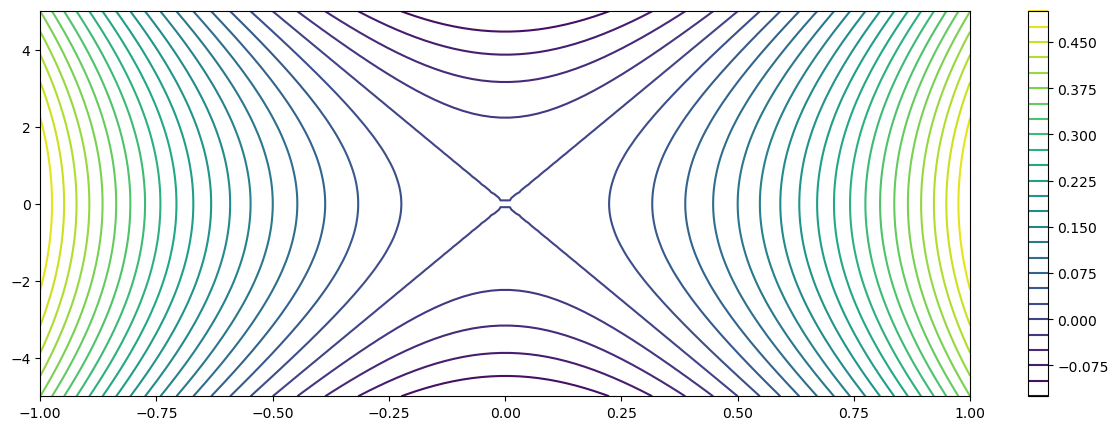

In [3]:
# Script for question 1 - Plotting the quadratic function in dimension 2

d = 2 
lbda = 0.01

# Defining the matrix A and the quadratic problem
A = np.eye(d)
A[d-1,d-1] = -lbda
pb_ncvx = QuadPb(A)


# Plot countours of the objective function over a subdomain containing 0
delta = 5
w1 = np.linspace(-1,1,100)
w2 = np.linspace(-delta,delta,100)
fw = [[pb_ncvx.fun(np.array([u1,u2])) for u1 in w1] for u2 in w2]
plt.figure(figsize=(15,5))
plt.contour(w1,w2,fw,levels=30)
plt.colorbar()

#### <span style="color:rgb(92,29,79)">Answer to question 1</span>

### <span style="color:rgb(92,29,79)">Question 2</span>

More generally, show that the point $\mathbf{0}$ is a strict saddle point of $q$, in the sense that for every $\epsilon>0$, we can find $\mathbf{u}$ and $\mathbf{v}$ such that $\|\mathbf{u}\|=\epsilon$ and $\|\mathbf{v}\|=\epsilon$ such that $q(\mathbf{u}) > q(\mathbf{0})=0 > q(\mathbf{v})$.

#### <span style="color:rgb(92,29,79)">Answer to question 2</span>


## <span style="color:rgb(92,29,79)">1.2 Running gradient descent</span>

We will run several instances of gradient descent on this problem, using the code from the previous lab session.

In [4]:
# Implementation of gradient descent - This code corresponds to that of the first lab session
def grad_desc(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000, verbose=True): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun(w) evaluates the objective function at a given vector w
                problem.d returns the expected length of the input
                problem.grad(w) evaluates the gradient of the objective function at a vector w
                problem.lipgrad() returns the Lipschitz constant for the gradient
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize (see above)
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/(k+1)
                2: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            w_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length at most n_iter)
            normits: History of distances between iterates and optimum (Numpy array of length at most n_iter)
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of current iterate   
    w = w0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        # Compute the gradient
        g = problem.grad(w)
        
        # Select the stepsize and perform the update
        if stepchoice==0:
            w[:] = w - (1/L) * g
        elif stepchoice==1:
            w[:] = w - (step0/(k+1))*g
        else:
            w[:] = w - (step0/(sqrt(k+1)))*g
        
        # Compute and plot the new objective value and distance to the minimum
        obj = problem.fun(w)
        objvals.append(obj)
        nmin = norm(w-wtarget)
        normits.append(nmin)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(normits)

In the code below, we use a bunch of initial points and check whether gradient descent converges to the saddle point $\mathbf{0}$ or manages to escape that saddle point, in the sense that it computes $\mathbf{w}_k$ such that $q(\mathbf{w}_k)<0$.

### <span style="color:rgb(92,29,79)">Question 3</span>

1) Run the script below with `failpt=False` to launch gradient descent from 100 different starting points. How many of those runs escape the saddle point? How does this confirm the property stated at the beginning of the notebook?

2) Find a point for which gradient descent will fail to escape the saddle point, and add it to the script in the appropriate location (set `failpt=True` to use this point). Do you indeed observe convergence to the saddle point?

#### <span style="color:rgb(92,29,79)">Answer to question 3</span>


GD escaped the saddle point  100  times out of  101  random trials
GD failed on the manually chosen starting point


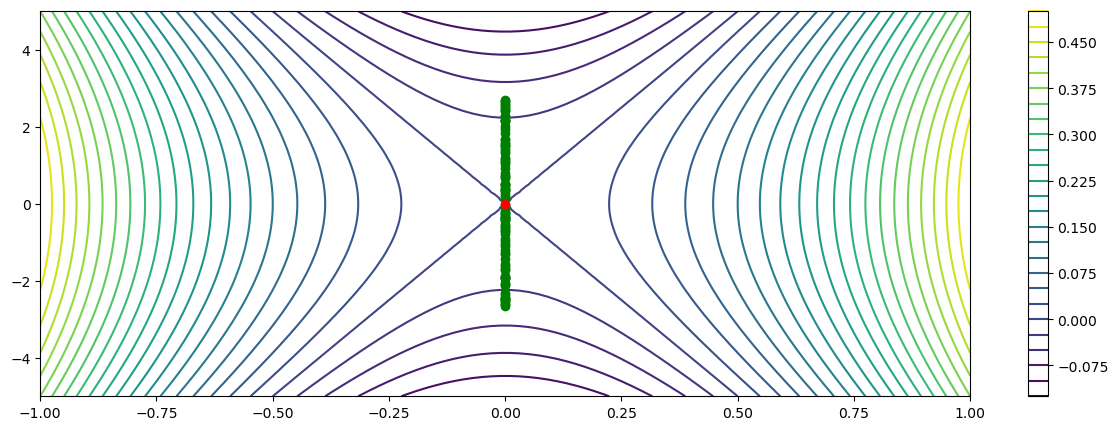

In [5]:
# Script related to question 3 - Change the dimension/the matrix as needed
##########################################################################

d = 2 
lbda = 0.01

# Defining the matrix A and the quadratic problem
A = np.eye(d)
A[d-1,d-1] = -lbda
pb_ncvx = QuadPb(A)


# Draw a bunch of random points and plot the result
ntrials = 100
w_min_lin = np.zeros(d)

# Boolean to introduce a known point of failure for the method
# CHANGE THIS FLAG BETWEEN QUESTION 3.1 AND 3.2
failpt = True
# Define initial points and final values according to the boolean
if failpt:
    Wf = np.zeros((ntrials+1,d))
    vf = np.zeros(ntrials+1)
else:
    Wf = np.zeros((ntrials,d))
    vf = np.zeros(ntrials)

# Counting the number of "good trials" (those for which GD escaped the saddle point)
goodtrials = 0

# Run multiple instances of GD
for i in range(ntrials):
    w0 = uniform([-1,-1],[1,1],size=d)
    Wf[i,:], obj_q, nits_q = grad_desc(w0,pb_ncvx,w_min_lin,stepchoice=0,step0=1, n_iter=100,verbose=False)
    vf[i] = obj_q[-1]
    if vf[i]<0:
        goodtrials += 1
        
# Add a point of failure for GD
if failpt:
    #####
    # TO BE COMPLETED: DEFINE A INITIAL POINT SO THAT GD GETS STUCK AT THE SADDLE POINT
    # w0 should contain that point
    w0 = 
    ######
    Wf[ntrials,:], obj_q, nits_q = grad_desc(w0,pb_ncvx,w_min_lin,stepchoice=0,step0=1, n_iter=100,verbose=False)
    vf[ntrials] = obj_q[-1]
    if vf[ntrials]<0:
        goodfailpt = 1
    else:
        goodfailpt = 0
        
print('GD escaped the saddle point ',goodtrials,' times out of ', ntrials+1,' random trials')
if goodfailpt:
    print('GD succeeded on the manually chosen starting point')
else:
    print('GD failed on the manually chosen starting point')
    
# Plot the results if dimension allows it
if d==2:
    npts = vf.size
    plt.figure(figsize=(15,5))
    plt.contour(w1,w2,fw,levels=30)
    plt.colorbar()
    for i in range(npts):
        if vf[i]<0:
            plt.plot(Wf[i,0],Wf[i,1],'o',color='green')
        else:
            plt.plot(Wf[i,0],Wf[i,1],'o',color='red')

# <span style="color:rgb(92,29,79)">Part 2 - Gradient descent for low-rank matrix completion</span>

In this section, we apply gradient descent to a nonconvex optimization formulation derived from the low-rank matrix completion setting. *This code is meant to complement Exercise 1.3, and to prepare the course homework.*

## <span style="color:rgb(92,29,79)"> 3.1 Problem data</span>

We consider a data matrix $\mathbf{M} \in \mathbb{R}^{d \times d}$ assumed to be symmetric positive semidefinite and low rank, which means that the number of positive eigenvalues of $\mathbf{M}$ is $r \ll d$, all the other eigenvalues being $0$. Given a limited number of observations $s$ of $\mathbf{M}$, our goal is to find an approximation of this matrix.

It can be shown that any matrix satisfying these assumptions can be written as $\mathbf{M}=\mathbf{U}\mathbf{U}^T$ with $\mathbf{U} \in \mathbb{R}^{d \times r}$. This decomposition is used in the code below to produce our problem data.

In [6]:
# Generate a random, low-rank matrix and get a sampled version
# This code is adapted from the lab session of Irène Waldspurger, M2 IASD 2020-2021.

def datamatrix(d,r,nb_s):
    '''
        Generation of a random, low-rank matrix as well as a subsampled matrix approximation.
        This code is adapted from the lab session of Irène Waldspurger at M2 IASD 2020-2021.
        
        Inputs:
            d: Matrix dimension (the output matrices will be d-by-d)
            r: Rank of the matrix
            nb_s: Number of subsampled entries
        
        Outputs:
            M: Data matrix, of size d x d and of rank r
            S: Mask defining the sampling pattern: size d x d, formed by zeroes and ones
            M_sampled: Subsampled matrix
            U: Factor data matrix
    '''

    # True low-rank factor and matrix
    U = randn(d,r)
    M = np.dot(U,np.transpose(U))

    # Consider a matrix partially filled out with s entries of M
    subset = choice(d*d,nb_s,replace=False)
    S = np.zeros(d*d)
    S[subset] = 1
    S = S.reshape((d,d))
    M_sampled = M*S # Entrywise product

    return M,S,M_sampled,U


We can plot the results as follows.

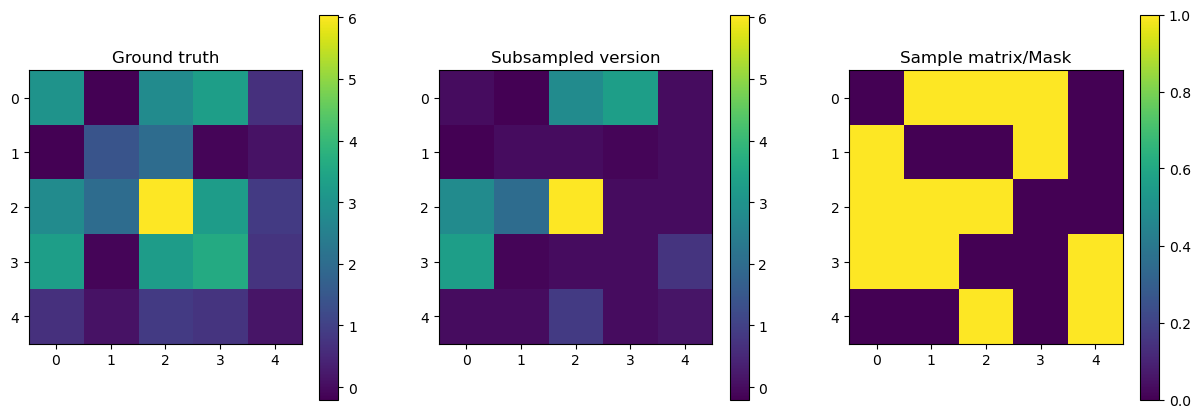

In [7]:
d = 5 # Matrix size is d*d
r = 2 # Intrisic rank
nb_s = 13 # Number of observed entries

# Fix random seed for reproducibility
np.random.seed(1)

M,S,M_sampled,U = datamatrix(d,r,nb_s)


# Plot the results
plt.figure(figsize=(15,5))
plt.get_cmap('twilight')
plt.subplot(131)
plt.title('Ground truth')
plt.imshow(M)
plt.colorbar()
plt.subplot(132)
plt.title('Subsampled version')
plt.imshow(M_sampled)
plt.colorbar()
plt.subplot(133)
plt.title('Sample matrix/Mask')
plt.imshow(S)
plt.colorbar()

## <span style="color:rgb(92,29,79)"> 3.2 Nonconvex formulation and derivatives</span>

We now focus on a nonconvex formulation of this problem. The classical, convex optimization approach consists in solving
$$
    \mathrm{minimize}_{\mathbf{W} \in \mathbb{R}^{d \times d}} \frac{1}{2} \sum_{(i,j) \in \mathcal{S}} \left( \mathbf{W}_{ij}-\mathbf{M}_{ij}\right)^2
$$
where $\mathcal{S} \subset \{1,\dots,d\}^2$ represents the set of entries of the data matrix $\mathbf{M}$ that are observed. This problem is convex, but requires the manipulation of a $d \times d$ matrix. In addition, the solution need not be low rank: in fact, to guarantee that the solution will possess the same properties add the constraint $\mathrm{rank}(\mathbf{W})=r$ in order for the problem to guarantee a low-rank approximation, plus a constraint of the form $\mathbf{W} \succeq \mathbf{0}$ to guarantee that $\mathbf{W}$ has (like $\mathbf{M}$) only nonnegative eigenvalues.

Overall, the problem we should look at is
$$
   \mathrm{minimize}_{\mathbf{W} \in \mathbb{R}^{d \times d}} \frac{1}{2} \sum_{(i,j) \in \mathcal{S}} \left( \mathbf{W}_{ij}-\mathbf{M}_{ij}\right)^2 \quad \mathrm{subject\ to} \quad 
   \mathbf{W}=\mathbf{W}^T \succeq \mathbf{0},\ \mathrm{rank}(\mathbf{W}) \le r.
$$

Instead of this formulation, we adopt the Burer-Monteiro approach and reformulate the problem using a factored representation of the problem variable $\mathbf{W}$ that highlights its low-rank structure. This leads to the following formulation:
$$
    \mathrm{minimize}_{\mathbf{U} \in \mathbb{R}^{d \times r}} \frac{1}{2}\sum_{(i,j) \in \mathcal{S}} \left( [\mathbf{U}\mathbf{U}^T]_{ij}-\mathbf{M}_{ij}\right)^2.
$$
Compared to the original formulation, our approximation of $\mathbf{M}$ is given by $\mathbf{U}\mathbf{U}^T$, which is by construction a rank-$r$ matrix, *but we only solve the problem in $\mathbf{U} \in \mathbb{R}^{d \times r}$*. This problem is unconstrained in $\mathbf{U}$ and involves only $dr$ variables by explicitly enforcing the low-rank 
property.

We would like to apply gradient descent to the following problem
$$
    \mathrm{minimize}_{\mathbf{U} \in \mathbb{R}^{d \times r}}\ f(\mathbf{U}):=
    \frac{1}{2}\sum_{(i,j) \in \mathcal{S}} \left([\mathbf{U}\mathbf{U}^T]_{ij}-\mathbf{M}_{ij}\right)^2
$$
There are two ways to approach this problem: the first one consists in viewing this problem as one on $\mathbb{R}^{dr}$, and do a standard gradient descent procedure. This approach allows for reusing our generic gradient descent code from above.

The second approach preserves the matrix structure of the variables, and defines the gradient of $f$ as a matrix in $\mathbb{R}^{d \times r}$ (similarly to the vector case, in which $\nabla \phi(\mathbf{x}) \in \mathbb{R}^d$ for any function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}$ and $\mathbf{x} \in \mathbb{R}^d$). In our case, we define the gradient of $f$ with respect to any $\mathbf{U} \in \mathbb{R}^{d \times r}$ as:
$$
    \nabla f(\mathbf{U}) := (\mathbf{E}+\mathbf{E}^T)\mathbf{U} \quad \mbox{where} \quad 
    \mathbf{E}:= (\mathbf{U}\mathbf{U}^T-\mathbf{M}) \otimes \mathbf{S},
$$
with $\otimes$ denoting the Hadamard/entrywise matrix product, and $\mathbf{S} \in \mathbb{R}^{d \times d}$ is 
defined by 

$$
    \mathbf{S}_{ij} = 
    \left\{
        \begin{array}{ll}
            1 &\mbox{if $(i,j) \in \mathcal{S}$} \\
            0 &\mbox{otherwise.}
        \end{array}
    \right.
$$

The two functions in the next block use this approach to encode the function value and its derivative.

In [8]:
# Objective function for the nonconvex matrix factorization problem
def f_mat(U,M_S,S):
    '''
        Function value for the low-rank matrix factorization problem.
        The solution of this problem is a matrix U such that U*U^T agrees as best as possible with M_S on its 
        non-zero entries.
        
        Inputs:
            U: d-by-r matrix (decision variables)
            M_S: Samples from the data matrix
            S: Sampling pattern
            
        Output:
            f: Value of the low-rank matrix functional at U
    '''
    E = np.dot(U,np.transpose(U))-M_S
    E = E * S
    return 0.5*np.sum(E**2)

# Objective and gradient vector for the nonconvex matrix factorization problem
def fg_mat(U,M_S,S):
    '''
        Objective and gradient vector for the low-rank matrix factorization problem.
        The solution of this problem is a matrix U such that U*U^T agrees as best as possible with M_S on its 
        non-zero entries.   
        
        Inputs:
            U: d-by-r matrix (decision variables)
            M_S: Samples from the data matrix
            S: Sampling pattern
            
        Output:
            f: Value of the low-rank matrix functional at U
            G: Value of the gradient of this functional (defined in a matrix sense) at U
    '''
    E = np.dot(U,np.transpose(U))-M_S
    E = E * S
    f = 0.5*np.sum(E**2)
    G = np.dot(E+np.transpose(E),U)
    return f,G

The *ad hoc* version of gradient descent for the low-rank matrix completion problem is given below. Note that it computes an adaptive stepsize through a backtracking line search procedure.

In [9]:
def gd_matrix(U0,fun,fungrad,f_base,step,linesearch=False,n_iter=10000, verbose=False): 
    """
        A code for gradient descent on low-rank matrix-type problems.
        
        Inputs:
            U0: Initial (rectangular) matrix
            fun: Objective function, returns f(U) for every U
            fungrad: Returns both the objective function and its gradient
            f_base: A base value to assess convergence
            step: Initial value of the stepsize
            linesearch: Boolean indicating whether or not a line search should be performed
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            U_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length at most n_iter+1)
            ngvals: History of gradient norms (output as a Numpy array of length at most n_iter+1)
            nits: Number of iterations actually performed
            flag: Termination flag
                0: Convergence in terms of function value (decrease of f_base by 1e-4)
                1: Convergence in terms of gradient norm (below 1e-3, normalized by norm(U_output))
                2: Maximum number of iterations reached
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # gradient norm history
    ngvals = []
    
    # Initial value of current iterate   
    U = U0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective and gradient value
    obj,G = fungrad(U)
    objvals.append(obj)
    ngrad = norm(G)
    ngvals.append(ngrad)

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))
    
    # Stopping boolean
    if (obj<=1e-4*f_base):
        flag=0
    elif (ngrad<=1e-3*norm(U)):
        flag=1
    else:
        flag=2
        
    stopping=(flag==2)
    
    ####################
    # Main loop
    while stopping:
        
        # Select the stepsize and perform the update
        if linesearch:
            if k>0:
                step = 1.1*step
            fval = fun(U-step*G)
            ngrad2 = ngrad**2
            # Loop to increase the value of L if necessary
            while (fval-obj>-0.5*step*ngrad2):
                step = step/2
                fval = fun(U-step*G)
        
        U = U - step * G
        
        # Compute the new objective and gradient
        obj,G = fungrad(U)
        objvals.append(obj)
        ngrad = norm(G)
        ngvals.append(ngrad)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
        
        # Stopping boolean
        if (obj<=1e-4*f_base):
            flag=0
        elif (ngrad<=1e-3*norm(U)):
            flag=1
        else:
            flag=2
        stopping = (flag==2)
    
    # End main loop
    ######################
    
    # Output
    U_output = U.copy()
    nits = k
        
    return U_output, np.array(objvals), np.array(ngvals),nits,flag

We can run this method on a small-scale example and observe that it does provide a good candidate solution.

0
Objective function: 3.2949706629448476e-05
Normalized gradient norm: 0.016902753742291554


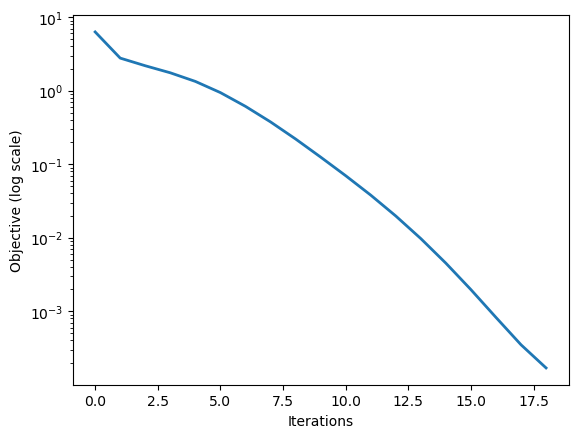

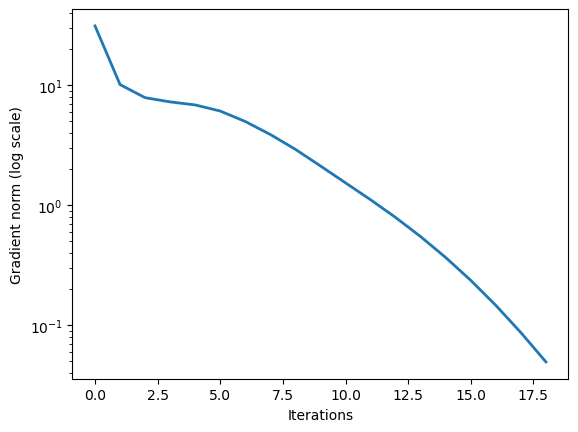

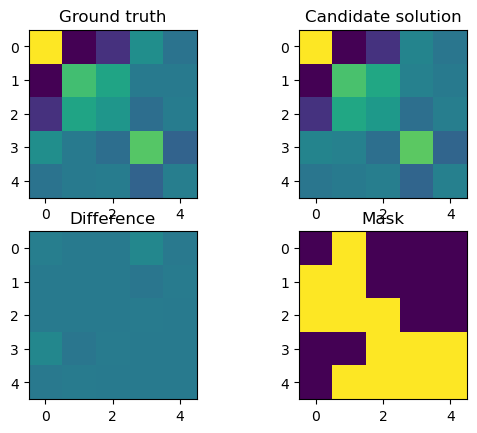

In [10]:
# Validation on a small-dimensional example

d=5
r=2
nb_s=13

M,S,M_s,U_star = datamatrix(d,r,nb_s)

fbase = 0.5*(np.sum(M_s**2))

# Run gradient descent
U0 = randn(d,r)
#U0 = U_star
U_out,obj_out,ng_out,nits,flag = gd_matrix(U0,lambda U: f_mat(U,M_s,S),lambda U: fg_mat(U,M_s,S),fbase,1.,True,10000,False)

#print(nits)
print(flag)
# Plot the results
print("Objective function:",obj_out[-1]/(norm(M_s)**2))
print("Normalized gradient norm:",ng_out[-1]/norm(U_out))
M_out = np.dot(U_out,np.transpose(U_out))

plt.figure(1)
plt.semilogy(obj_out/norm(M_s), lw=2)
plt.xlabel('Iterations')
plt.ylabel('Objective (log scale)')
plt.figure(2)
plt.semilogy(ng_out, lw=2)
plt.xlabel('Iterations')
plt.ylabel('Gradient norm (log scale)')
plt.figure(3)
plt.subplot(221)
plt.title('Ground truth')
plt.imshow(M)
plt.subplot(222)
plt.title('Candidate solution')
plt.imshow(M_out,vmin=np.amin(M_out),vmax=np.amax(M_out))
plt.subplot(223)
plt.title('Difference')
plt.imshow(M-M_out,vmin=np.amin(M_out),vmax=np.amax(M_out))
plt.subplot(224)
plt.title('Mask')
plt.imshow(S)

We now consider running gradient descent on multiple instances of this problem (i.e. use multiple data matrices).
For any instance, we consider that
- GD converges to a solution if the final function value is below $10^{-4}\|\mathbf{M}_S\|^2$;
- GD converges to a critical point but not a solution if the previous test fails but the final gradient norm is below $10^{-3}\|\mathbf{U}_K\|$, where $\mathbf{U}_K$ is the last iterate;
- GD fails to converge otherwise.

We compare the number of solved/converged/failed instances as we increase the number of observations.

10 Samples out of 81
12 Samples out of 81
14 Samples out of 81
16 Samples out of 81
18 Samples out of 81
20 Samples out of 81
22 Samples out of 81
24 Samples out of 81
26 Samples out of 81
28 Samples out of 81
30 Samples out of 81
32 Samples out of 81
34 Samples out of 81
36 Samples out of 81
38 Samples out of 81


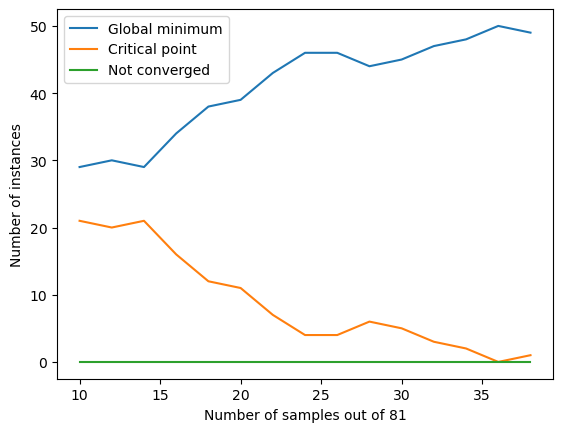

In [11]:
# Implementation - Running multiple instances

d=9
r=1
vals_s = range(10,40,2)
len_s = len(vals_s)
counter = np.zeros((len_s,3))
#
for n_it in range(0,len_s):
    nb_s = vals_s[n_it]
    print(str(nb_s) + ' Samples out of '+str(d**2)),
    for i in range(0,50):
        M,S,M_s,U_star = datamatrix(d,r,nb_s)
        nMs2 = 0.5*norm(M_s)**2
        U0 = randn(d,r)
        U_out,obj_out,ng_out,_,flag = gd_matrix(U0,lambda U: f_mat(U,M_s,S),lambda U: fg_mat(U,M_s,S),nMs2,1.,True,20000,False)
        counter[n_it,flag]+=1
#
plt.xlabel('Number of samples out of '+str(d**2))
plt.ylabel('Number of instances')
plt.plot(vals_s,counter[:,0],label='Global minimum')
plt.plot(vals_s,counter[:,1],label='Critical point')
plt.plot(vals_s,counter[:,2],label='Not converged')
plt.legend()

In [12]:
# Version 4.0 - C. W. Royer, October 2024